In [1]:
import numpy as np
import pandas as pd
import random
import time
import math
import copy
import matplotlib.pyplot as plt

In [2]:
'''These lines load real household data from a CSV file, filter data for a specific area, 
    extract counts and total persons, and calculate proportions of real data.'''

df = pd.read_csv('Household_data.csv') 
df_mainz = df[df['area'] == 'Mainz, St.']
real_data_counts = df_mainz[['Single_Person', 'Two_Person', 'Three_Person', 'Four_Person', 'Five_Person', 'Six_Person']].values[0]
total_persons = df_mainz['total_Person'].values[0]
proportions_of_real_data = real_data_counts / total_persons
print(proportions_of_real_data)

[0.46097651 0.30113725 0.11771419 0.07936369 0.02716331 0.01364505]


In [3]:
'''This function generates synthetic data representing the choice of settings for a given number of persons. 
It creates a list with a length of num_persons, and each element is a random choice between 1 and num_settings.'''

def generate_synthetic_data(num_persons, num_settings):
    return [random.choice(range(1, num_settings + 1)) for _ in range(num_persons)]

In [4]:
'''This function calculates the fitness of a given solution based on its deviation from target proportions. 
It uses a histogram to count occurrences of settings in the solution, converts the counts to proportions, and 
compares them to the target proportions.'''
def calculate_fitness(solution, target_proportions):
    counts = [solution.count(i) for i in range(1, num_settings + 1)]
    distribution = np.histogram(counts, bins=range(1, 7))[0]
    distribution = np.append(distribution, sum(counts >= 6 for counts in counts))
    z=sum(distribution)
    proportions = [(val/z) for val in distribution]
    return np.max(np.abs(np.subtract(proportions,target_proportions)))

In [5]:
'''This function performs mutation on a given solution U. 
    It creates a deep copy of the solution, randomly selects Nm unique indices, and assigns random settings to those indices.'''

def mutation_method(U, Nm, num_settings):
    U_copy = copy.deepcopy(U)  # Create a deep copy of the solution
    unique_indices = random.sample(range(len(U_copy)), Nm)
    for i in range(Nm):
        random_index = unique_indices[i]
        random_house_number = random.randint(1, num_settings)
        U_copy[random_index] = random_house_number
    return U_copy

In [6]:
'''This function performs crossover between two parent solutions. 
    It randomly selects a crossover point and combines parts of the parents to create two new solutions.'''

def crossover(parent1, parent2):
    point = random.randint(1, len(parent1) - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

In [7]:
'''This function implements a Differential Evolution Algorithm (DEA) to optimize the given candidate solutions. 
  It iteratively performs crossover and mutation to generate new solutions and selects the best ones based on fitness.'''

def DEA(candidate_solutions,R,nms,npm,ni):
    cs=candidate_solutions
    for iteration in range(ni):
        new_candidates = []
        for s in range(len(cs)):
            new_candidates.append(cs[s])
        random_candidate_solution_crossover = random.choices(range(len(cs)), k=2 * R)
        for i in range(0, len(random_candidate_solution_crossover) - 1, 2):
            parent1 = cs[random_candidate_solution_crossover[i]]
            parent2 = cs[random_candidate_solution_crossover[i + 1]]
            child1, child2 = crossover(parent1, parent2)
            new_candidates.append(child1)
            new_candidates.append(child2)
        random_candidate_solution_mutation = random.choices(range(len(cs)), k=nms)
        for i in random_candidate_solution_mutation:
            new_candidates.append(mutation_method(cs[i], npm, num_settings))
        fitness_scores = [calculate_fitness(solution, proportions_of_real_data) for solution in new_candidates]
        min_fitness_indices = np.argsort(fitness_scores)[:num_candidate_solution]
        cs = [new_candidates[i] for i in min_fitness_indices]
    return cs[0]


In [8]:
# Parameters
num_persons = 1000
num_settings = 550
num_candidate_solution = 30
Z= 7
num_mutation_solutions = 15
num_iterations = 30
place_mutate = [50,100,150,200,250,300,350,400]

In [9]:
all_times = []
all_fitnesses = []
# Evaluate different numbers of place mutate each for 6 times.
for num_place_mutate in place_mutate:
    times = []
    fitnesses = []
    for _ in range(6):  # Repeat experiment to average results
        start_time = time.time()
        solutions = [generate_synthetic_data(num_persons, num_settings) for _ in range(num_candidate_solution)]
        optimized_solutions = DEA(solutions, Z, num_mutation_solutions, num_place_mutate, num_iterations)
        times.append(time.time() - start_time)
        fitnesses.append(calculate_fitness(optimized_solutions, proportions_of_real_data))
    all_times.append(times)
    all_fitnesses.append(fitnesses)

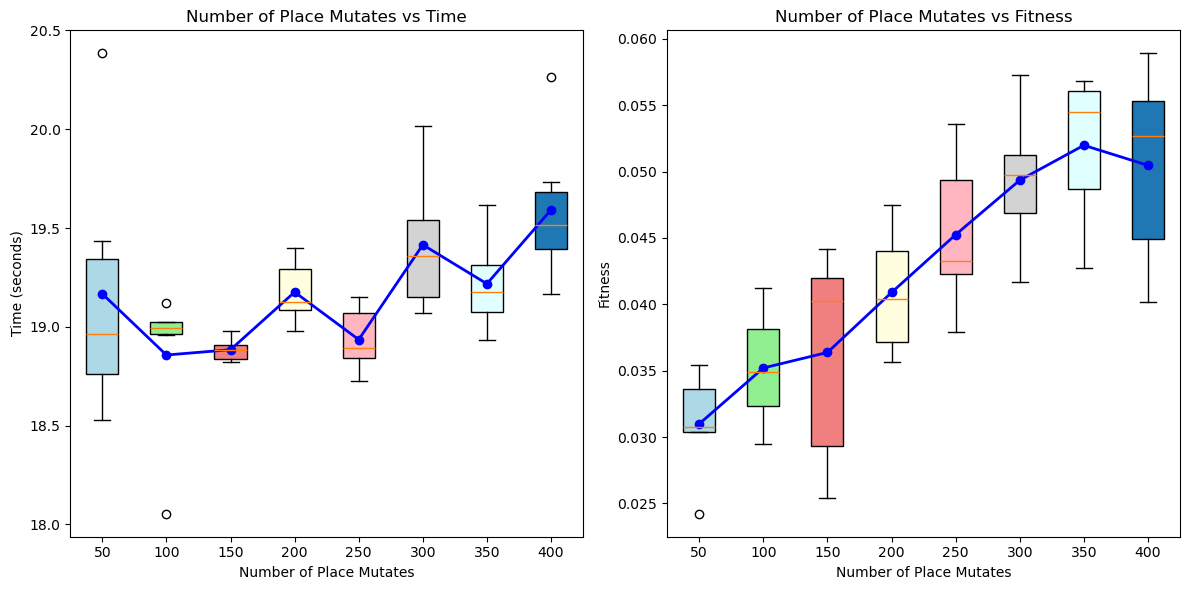

In [10]:
# Plot results
plt.figure(figsize=(12, 6))

# Plot boxplot of Number of Place Mutates with respect to Time
plt.subplot(1, 2, 1)
boxplot_times = plt.boxplot(all_times, labels=place_mutate, patch_artist=True)
for box, color in zip(boxplot_times['boxes'], ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgrey', 'lightcyan']):
    box.set_facecolor(color)
plt.xlabel('Number of Place Mutates')
plt.ylabel('Time (seconds)')
plt.title('Number of Place Mutates vs Time')
# Connect means with lines
means_times = np.mean(all_times, axis=1)
plt.plot(range(1, len(place_mutate)+1), means_times, marker='o', color='blue', linestyle='-', linewidth=2)

# Plot boxplot of Number of Place Mutates with respect to Fitness
plt.subplot(1, 2, 2)
boxplot_fitnesses = plt.boxplot(all_fitnesses, labels=place_mutate, patch_artist=True)
for box, color in zip(boxplot_fitnesses['boxes'], ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'lightgrey', 'lightcyan']):
    box.set_facecolor(color)
plt.xlabel('Number of Place Mutates')
plt.ylabel('Fitness')
plt.title('Number of Place Mutates vs Fitness')
# Connect means with lines
means_fitnesses = np.mean(all_fitnesses, axis=1)
plt.plot(range(1, len(place_mutate)+1), means_fitnesses, marker='o', color='blue', linestyle='-', linewidth=2)

plt.tight_layout()
plt.show()
